# Computational Discovery of Candidates for Neuron Exosome Isolation

## Siddharth Iyer

This notebook will guide you through our method for producing candidates for cell-type specific exosome isolation from the brain.

In [35]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sp
from scipy import stats
import os
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from itertools import compress

#custom functions for processing data
from surface_marker_utils import *

#custom functions to import proteomics/expression/annotation data
from import_surfacemarker_data import *

## Importing Protein Annotations

Protein transmembrane annotations are from Uniprot. All proteins/genes in this analysis are converted and analyzed as uniprot IDs. 

In [36]:
print('Importing protein annotations/ID conversions...')

oldTMU, TMU, ec_tmu, i2u, g2u, u2g, oldg2u, oldu2g = import_proteins();
allTMU = set(oldTMU + TMU)

surfaceome_TMU = import_surfaceome();

print('Done!')

Importing protein annotations/ID conversions...


100%|████████████████████████████████| 203711/203711 [00:03<00:00, 60933.81it/s]
/Users/siddharthiyer/Dropbox (MIT)/DAT/Computational/Surface_Markers/bin/import_surfacemarker_data.py:22: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  annotations = pd.read_csv('../data/prot_ann/uniprotkb_homo_sapiens_AND_model_organi_2023_12_06.tsv',  sep='\t')


Done!


## Importing Gene Expression Data
Datasets being used are GTEx, Brain RNA-seq (Zhang et al 2016), and HPA

In [4]:
#GTEx data
compiled_gtex, gtex_genes = import_GTEx(); 

#Brain RNA seq data
compiled_brs, brs_genes = import_brain_RNAseq() 

#HPA data
hpa_ihc, hpa_ihc_genes, hpa_rna, hpa_rna_genes, hpa_consensus, hpa_consensus_genes  = import_hpa_data()

#printing cell-types for user to choose
print('Cell-types in Brain RNA-seq:\n')
for cell_type in compiled_brs.columns[:]:
    print(cell_type)
scrna_data = pd.read_csv('../data/neuron_gene_attributions_fromGraham.csv')


Cell-types in Brain RNA-seq:

astrocytes
neurons
oligodendrocytes
microglia
endothelial


## Choose your cell type!
Enter your desired brain cell-type from the above types

In [5]:
brain_cell_type = 'neurons';

## Importing Proteomics Data
Datasets being used are our CaptoCore mass-spec (denoted DT_MS), HPPP, IPSC proteomics data,
and various past mass spectrometry datasets for both total CSF and CSF-derived EVs.

In [6]:
print('Importing mass spectrometry data...')

#captocore-isolated exosome proteomics 
mass_spec_plasma_cc, mass_spec_csf_cc, mass_spec_neuron_cc = import_MS_DT();

#iPSC proteomics
IPSC_uniprots = import_IPSC_data(brain_cell_type, g2u, oldg2u)

#HPPP data
HPPP_plasma_cc, HPPP_ev_cc = import_HPPP();

#Past CSF total/EV datasets
CSF_totals, CSF_EVs, CSF_total_names, CSF_EV_names = import_past_CSF_MS(i2u)
mass_spec_names = ['DT Mass Spec - Plasma', 'DT Mass Spec - CSF', 'DT Mass Spec - Neuron Culture',
                   'HPPP - Plasma', 'HPPP - CSF', 'iPSC Proteomics'] + CSF_total_names + CSF_EV_names;

mass_spec_data = [mass_spec_plasma_cc, mass_spec_csf_cc, mass_spec_neuron_cc, 
                 HPPP_plasma_cc, HPPP_ev_cc, IPSC_uniprots] + CSF_totals + CSF_EVs
print('Done!')

Importing mass spectrometry data...
Done!


## Tau Calculation Function
This function takes in a pseudologged expression dataset, 
gene list (in uniprot format), and the index of a specific cell/tissue-type.
It outputs a dataframe containing tau scores, and booleans denoting whether the gene 
was expressed most in the specific cell/tissue-type, and whether it was a valid uniprot ID.

There's also a function to specifically process HPA data.

In [59]:
def tau_calc(exp_dataset, gene_list_uniprot, idx):
    
    tau_df = pd.DataFrame(gene_list_uniprot, columns = ['Gene']);
    taus = []
    max_types = []
    valid_uniprot = []
    valid_max = []

    for g, gene in enumerate(gene_list_uniprot): #iterate through every gene as a uniprot ID
        
        #extract the pseudologged expression profile of the gene across cell-type/tissues
        profile = exp_dataset[g,:] 
        
        T = 0;
        max_type = False;
        
        #if the gene has nonzero expression
        if max(profile) > 1: 
            #unit-scale profile
            profile = profile/max(profile); 
            
            #calculate Tau
            T = sum((1-profile)/(profile.size-1));
            
            #save whether maximal expression is in right cell-type/tissue
            max_type = np.argmax(profile) == idx;
            
        taus.append(T);
        max_types.append(max_type);
        
        #checking whether gene is a valid uniprot ID
        valid_uniprot.append(gene != 'null');
        valid_max.append(gene != 'null' and max_type)
        
        if gene == 'Q5HZK2':
            print(profile, g)
            
    tau_df['Tau'] = taus;
    tau_df['Maximum'] = max_types;
    tau_df['Valid_Uniprot'] = valid_uniprot;
    tau_df['Valid_Max'] = valid_max
    
    #creating separate dataframe for only valid genes with max in the right cell-type/tissue
    max_taus = tau_df.loc[tau_df.Valid_Max,:]
    return tau_df, max_taus

#running pseudologging, tau calculation, and distribution plot for HPA
def data_tau_process(expression_data, name, genes):
    
    pl_data = np.log2(expression_data.values.astype(float)+1);
    genes_uniprot = uniprot_conversion(genes, g2u, oldg2u);
    
    if name == 'Brain_RNA-Seq':
        type_idx = list(expression_data.columns).index(brain_cell_type);
    else:
        type_idx = list(expression_data.columns).index('Brain');
        
    tau, type_tau = tau_calc(pl_data, genes_uniprot, type_idx)
    
    title= name +' Brain-Maximum Tau Distribution';
    path = name+'_brain_max.pdf'
    plot_tau_kde(type_tau.Tau.values,title,path)
    return tau, type_tau


## Applying Tau calculations and outputting smoothened histograms

The following block will process all the expression datasets to output datasets containing Tau scores.


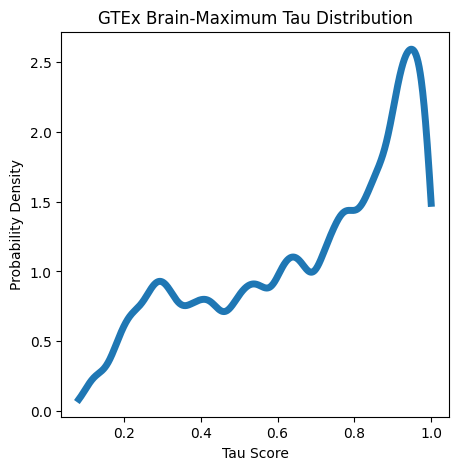

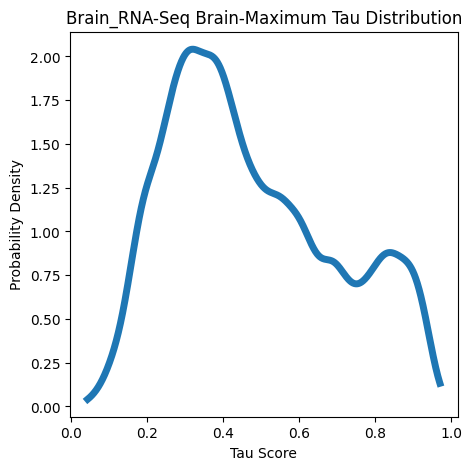

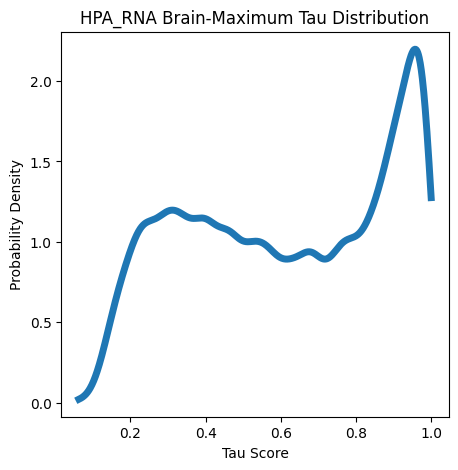

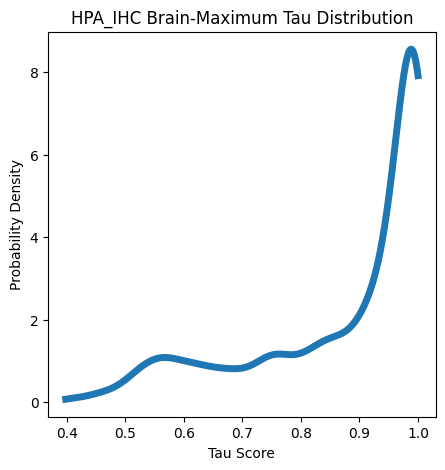

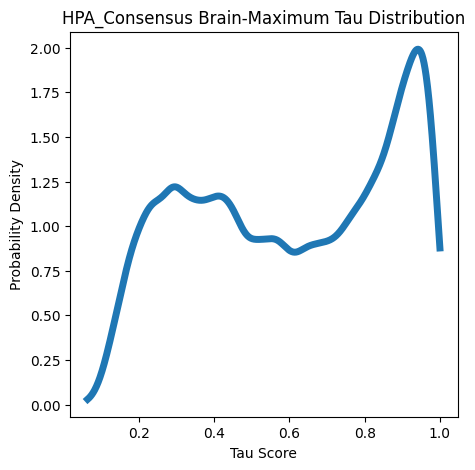

In [60]:
#creating lists of expression datasets, names, and gene lists
df_names = ['GTEx', 'Brain_RNA-Seq', 'HPA_RNA', 'HPA_IHC', 'HPA_Consensus'];
tau_dfs = []
max_tau_dfs = []
dfs = [compiled_gtex, compiled_brs, hpa_rna, hpa_ihc, hpa_consensus];
gene_lists = [gtex_genes, brs_genes, hpa_rna_genes, hpa_ihc_genes, hpa_consensus_genes];

#iterating through and calculating tau
for df, df_name, gene_list in zip( dfs, df_names, gene_lists):
    tau_df, max_tau_df = data_tau_process(df, df_name, gene_list);
    tau_dfs.append(tau_df);
    max_tau_dfs.append(max_tau_df)

#splitting out into separate dataframes
[gtex_tau, brs_tau, hpa_rna_tau, hpa_ihc_tau, hpa_consensus_tau] = tau_dfs; 
[gtex_brain_tau, cell_type_tau, hpa_rna_brain_tau, hpa_ihc_brain_tau, hpa_consensus_brain_tau] = max_tau_dfs;

## Dataset Counts

This block displays a bar graph that summarizes counts of genes in different categories for the expression datasets.

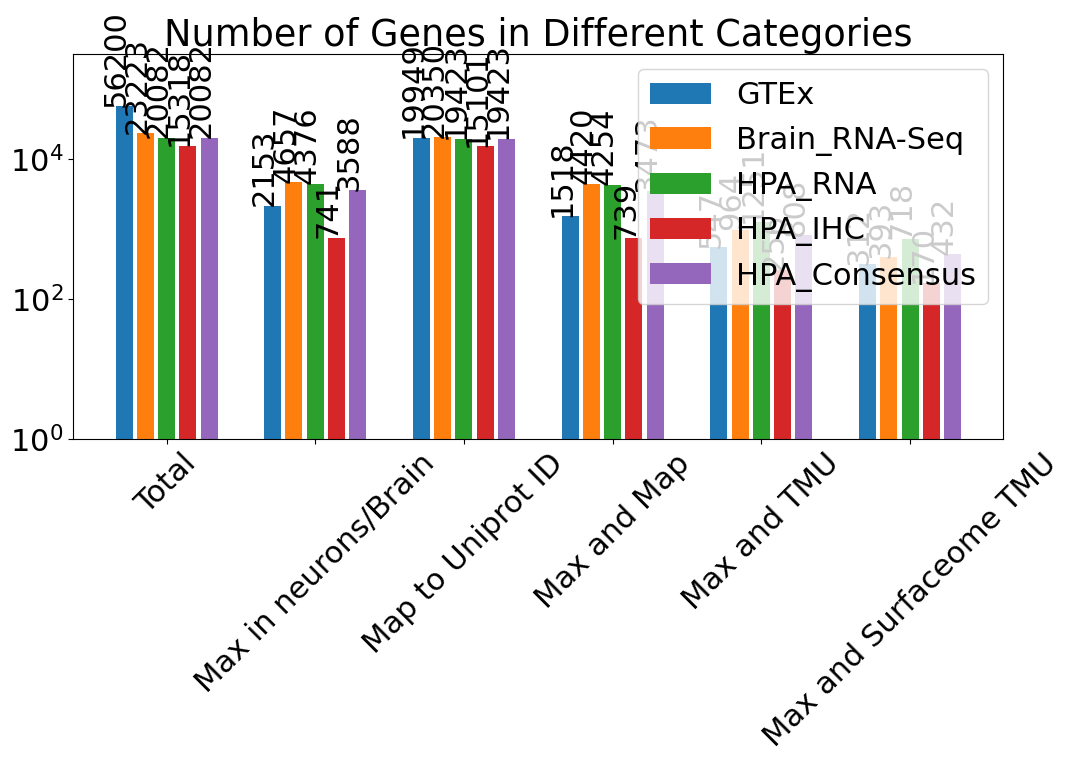

In [18]:
#plotting dataset counts
fig, ax = plt.subplots(figsize = (12,5))
ind = np.arange(0,6)*7;
ax.set_xticks(ind+2, ['Total', 'Max in {}/Brain'.format(brain_cell_type), 'Map to Uniprot ID',
                         'Max and Map', 'Max and TMU', 'Max and Surfaceome TMU'], rotation= 45 )
#matrix to store counts
count_mat = np.zeros((6, len(tau_dfs)))
for i, (df, max_tau_df, name) in enumerate(zip(tau_dfs,max_tau_dfs, df_names)): 
    count_mat[:4,i] = df.shape[0], sum(df.Maximum), sum(df.Valid_Uniprot), sum(df.Valid_Max)
    count_mat[4,i] = len(intersection(max_tau_df.Gene, allTMU));
    count_mat[5,i] = len(intersection(max_tau_df.Gene, surfaceome_TMU))
    
    height = count_mat[:,i];
    x = ind + i;
    ax = plt.bar(x = x, height = height)
    
    s = [str(int(c)) for c in count_mat[:,i]]
    y = height*1.2
    for xi, yi, si in zip(x+0.3,y,s):
        plt.text(xi, yi, si, ha= 'right', rotation = 90)
        
plt.title('Number of Genes in Different Categories')
plt.yscale('log');
plt.ylim([1,10**5.5])
plt.legend(df_names);
plt.savefig('../results/counts.pdf')


## Scatterplot of Tau Values for Brain RNA-seq and GTEx

Creating unified gene lists...


/var/folders/gb/l_9yrcn9127fsyvjflq7y49m0000gn/T/ipykernel_42202/3043860536.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


Unifying tau dataframes...
Creating scatterplots of tau-score with all genes or only genes expressed most in brain/neurons
          out of all tissues/cell-types, and with all types of proteins
          or only transmembrane proteins...


55321it [00:02, 19210.19it/s]
631it [00:00, 18463.83it/s]
4925it [00:00, 18368.43it/s]
230it [00:00, 18228.18it/s]


Done!


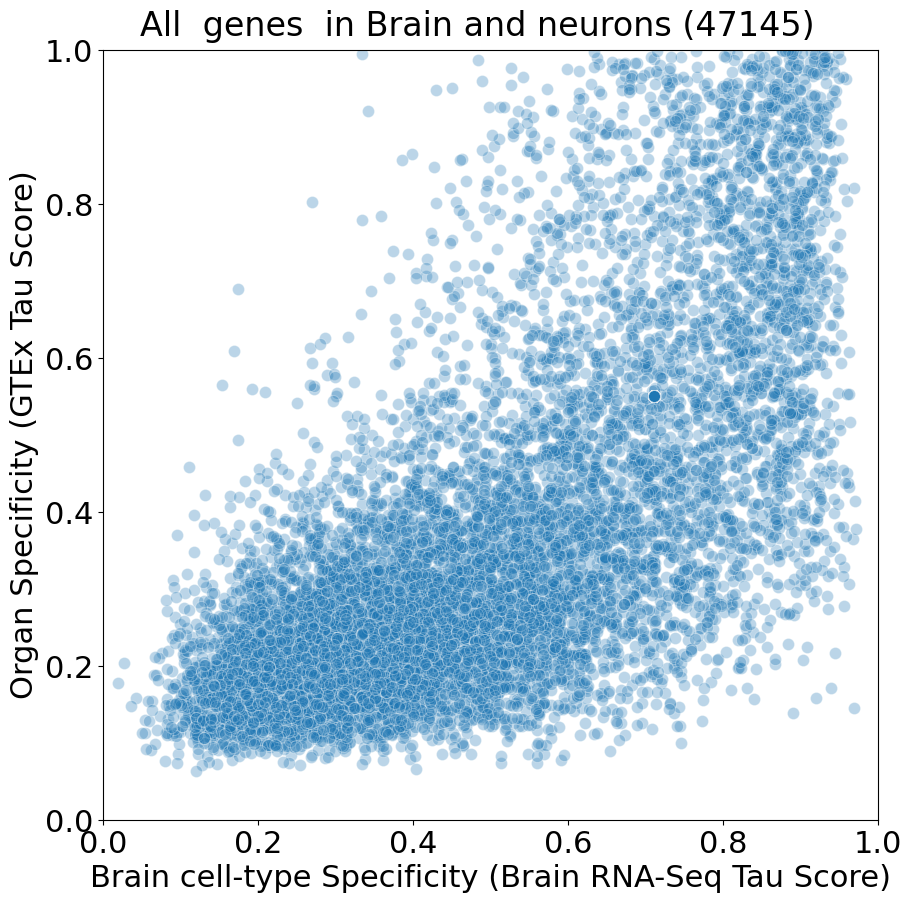

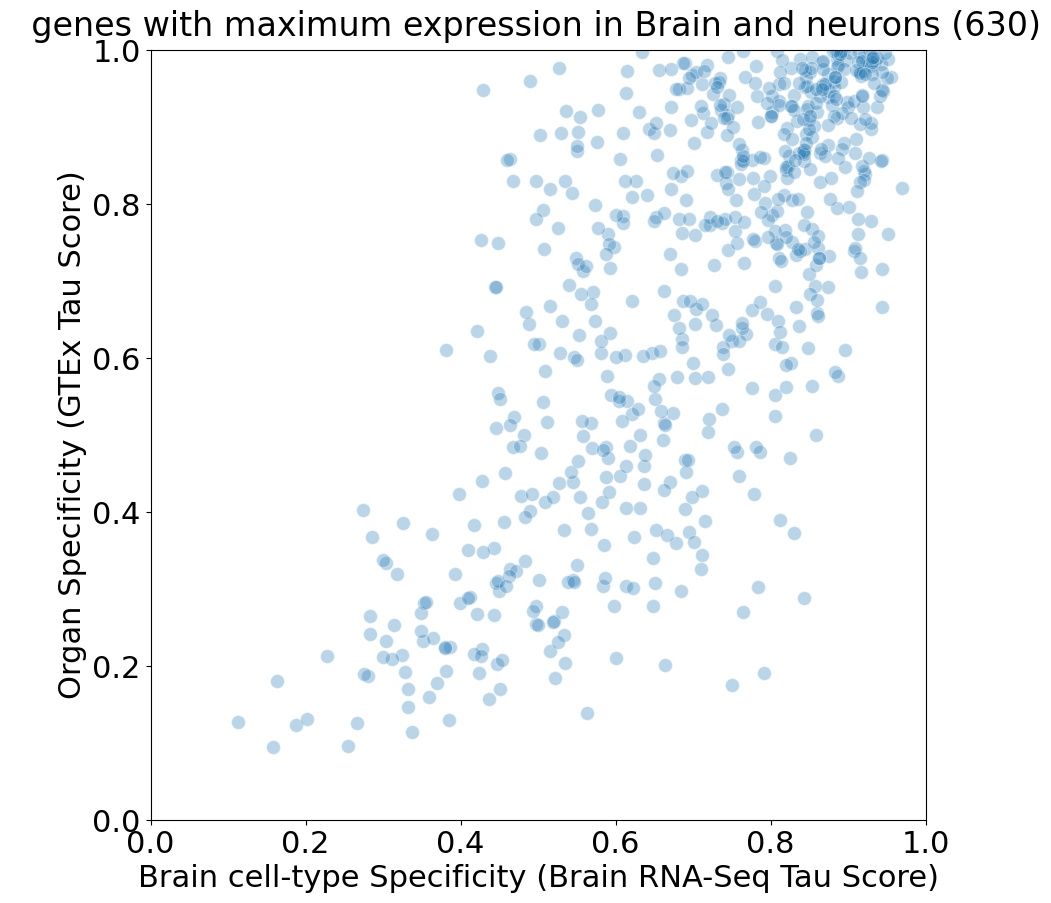

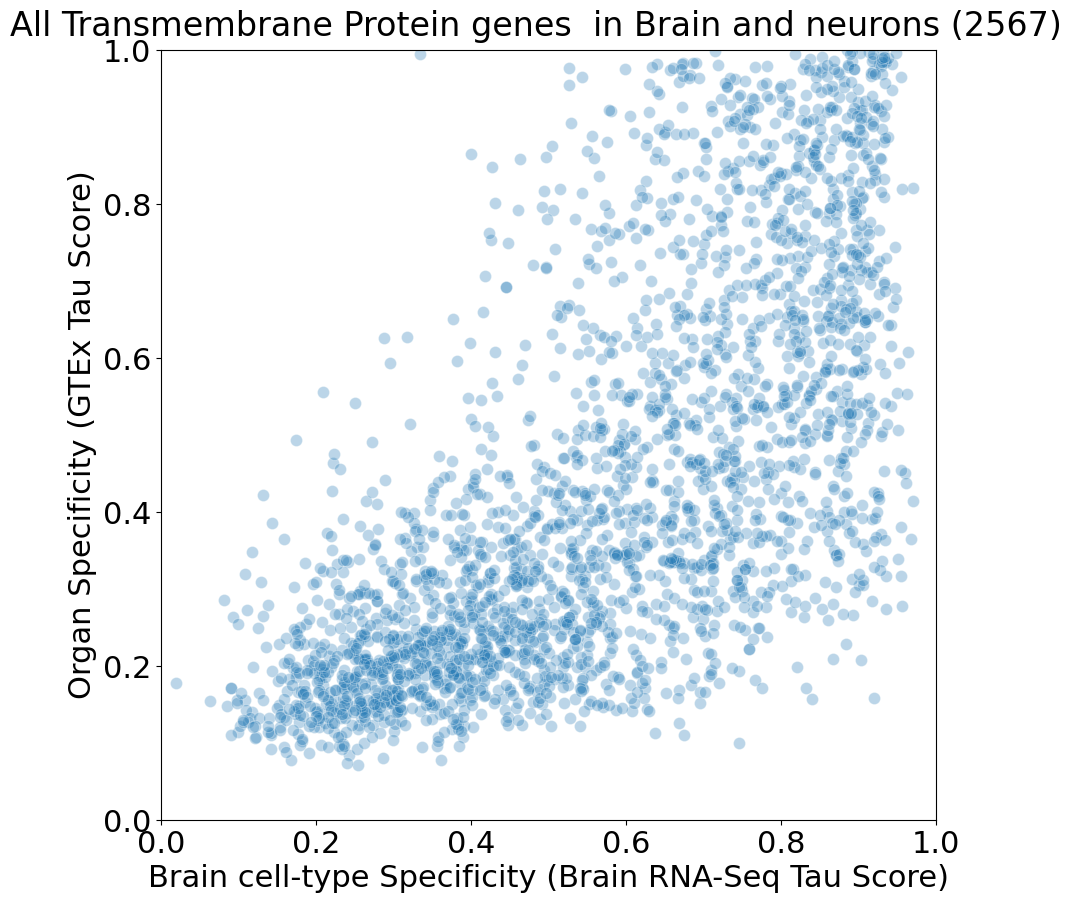

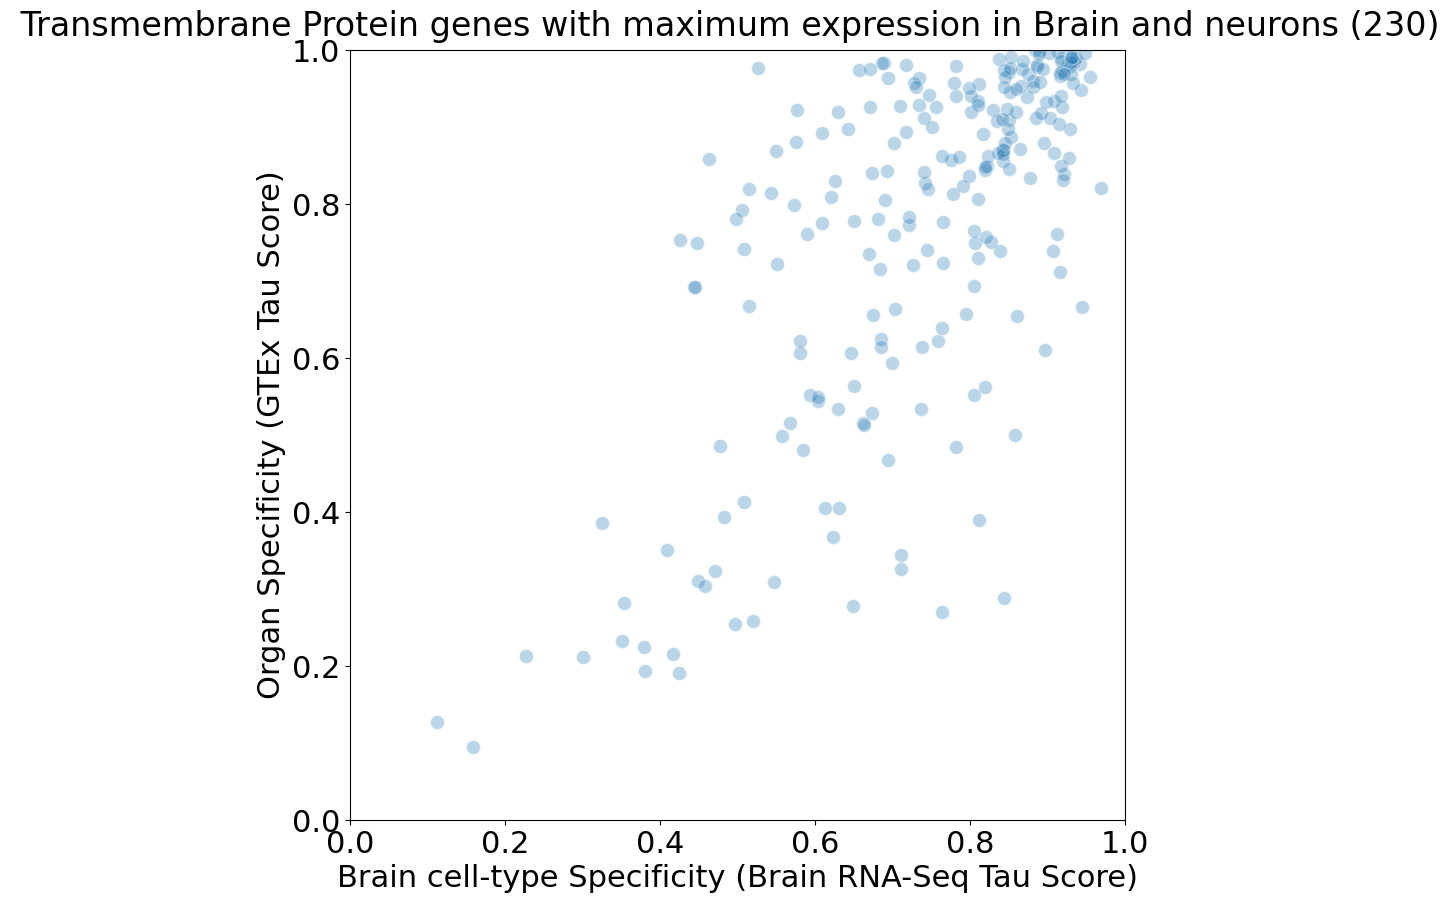

In [34]:
# 
print('Creating unified gene lists...')

#dictionaries for each dataset that store what index every gene corresponds to 
u2idx_dicts = [dict(zip(df.Gene,np.arange(len(df.Gene)))) for df in tau_dfs]

#lists of genes in common between GTEx and brain RNA seq
full_uniprots = intersection(list(gtex_tau.Gene), list(brs_tau.Gene))

#those which are maximum in both for brain/cell-type
# max_uniprots = intersection(list(gtex_brain_tau.Gene), list(brs_tau.Gene))
max_uniprots = intersection(list(gtex_brain_tau.Gene), list(cell_type_tau.Gene))

full_uniprots_TMU = intersection(full_uniprots, allTMU)

max_uniprots_TMU = intersection(max_uniprots, allTMU)

print('Unifying tau dataframes...')
print('''Creating scatterplots of tau-score with all genes or only genes expressed most in brain/{}
          out of all tissues/cell-types, and with all types of proteins
          or only transmembrane proteins...'''.format(brain_cell_type))
plt.rcParams.update({'font.size': 22})

from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
def myplot(x, y, s=16, bins=100):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
#     heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

#creates unified dataframe to store both values together and makes scatterplot
for uniprot_list, name in zip([full_uniprots, max_uniprots, full_uniprots_TMU, max_uniprots_TMU, ], 
                ['All', 'Maximum', 'All_TMU', 'Maximum_TMU']):
    
    #empty matrix to store values
    full_taus = np.zeros((len(uniprot_list), 2));
    plt.figure(figsize = (10,10)) 
    
    #iterate through all uniprot IDs, grab the tau value from each dataset, and store appropriately
    for i, uniprot in tqdm(enumerate(uniprot_list)):
        full_taus[i,0] = gtex_tau.iloc[u2idx_dicts[0][uniprot]]['Tau']
        full_taus[i,1] = brs_tau.iloc[u2idx_dicts[1][uniprot]]['Tau']
        
#         denotes specifically where some specific candidate markers are
#         if uniprot in [g2u[g] for g in ['L1CAM', 'NCAM1', 'GRIA2', 'ATP1A3']]:
#             plt.scatter(full_taus[i,1],full_taus[i,0], c = 'k', s = 50, alpha= 1)
#             plt.annotate(u2g[uniprot], (full_taus[i,1]-0.08,full_taus[i,0]+0.02), c = 'k')
       
    full_tau_df = pd.DataFrame(full_taus, columns = ['GTEx', 'Brain_RNA-Seq' ])
    full_tau_df = full_tau_df.loc[~(full_tau_df==0).any(axis=1)]
    
    #full scatterplot of all common genes
    qualifier = ''
    gene_type = ''
    beginner = ''
    if 'All' in name:
        size = 75
        beginner = 'All'
    if 'Maximum' in name:
        size = 100
        qualifier = 'with maximum expression'
    if 'TMU' in name:
        gene_type = 'Transmembrane Protein'

    # heatmap, extent = myplot(full_tau_df['Brain_RNA-Seq'], full_tau_df['GTEx'], s= 0.8, bins = 60)
    # plt.imshow(heatmap, extent = extent, origin = 'lower', cmap = cm.Blues)
    # plt.colorbar(shrink = 0.7)
    plt.ylabel('Organ Specificity (GTEx Tau Score)')
    plt.xlabel('Brain cell-type Specificity (Brain RNA-Seq Tau Score)')
    sns.scatterplot(x = 'Brain_RNA-Seq', y = 'GTEx', alpha = 0.3, s= size, data = full_tau_df)
    plt.suptitle('{} {} genes {} in Brain and {} ({})'.format(beginner,gene_type, 
                                                         qualifier, brain_cell_type, full_tau_df.shape[0])
                 , size=24, y=0.92); 
    plt.ylim((0,1))
    plt.xlim((0,1))
    path = '../results/tau_scatterplot_' + name + '.pdf'
    plt.savefig(path)
    
print('Done!')

## Isolating only Transmembrane Proteins and Looking at Different Cutoffs

This block will produce a dataframe with only transmembrane proteins that are expressed maximally in the brain and your desired cell type. Then it produces a heatmap that shows how different cutoffs for Tau will result in a different number of desired markers.

230it [00:00, 6575.17it/s]


There are 230 transmembrane proteins with maximum in brain/neurons.



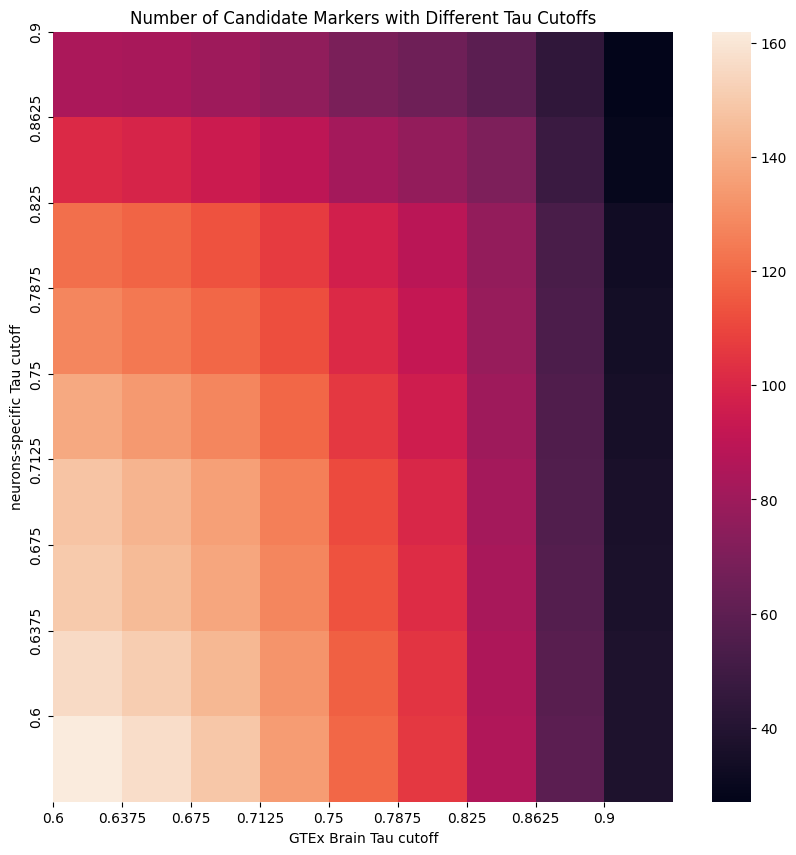

In [43]:
#filtering to only TMU
# max_uniprots_TMU = [uniprot for uniprot in max_uniprots if uniprot not in allTMU]
max_uniprots_TMU = intersection(max_uniprots, allTMU)
# max_uniprots_TMU = intersection(max_uniprots, surfaceome_TMU)
# max_uniprots_TMU = max_uniprots
# max_uniprots_TMU = full_uniprots
tau_mat = np.zeros((len(max_uniprots_TMU),5))

#creating new matrix to store Tau values across expression datasets for TMUs with max in brain/cell-type
gene_names= []
for i, uniprot in tqdm(enumerate(max_uniprots_TMU)):
    if uniprot in u2g:
        gene_names.append(u2g[uniprot]);
    elif uniprot in oldu2g:
        gene_names.append(oldu2g[uniprot])
    for j, tau_df in enumerate(tau_dfs):
        if uniprot in u2idx_dicts[j]:        
            tau_mat[i,j] = tau_df.iloc[u2idx_dicts[j][uniprot]]['Tau'];

#making dataframe with uniprot IDs and gene names
master_tau_df = pd.DataFrame(tau_mat, columns = df_names)

master_tau_df['Uniprot ID'] = max_uniprots_TMU;
master_tau_df['Gene name'] = gene_names;
master_tau_df = master_tau_df.set_index('Uniprot ID')
master_tau_df = master_tau_df.set_index('Gene name', append= True)

#summing tau values
master_tau_df['Tau Sum'] = np.sum(tau_mat, axis = 1);
master_tau_df = master_tau_df.sort_values('Tau Sum')

#plotting number of genes left after different cutoff values between 0.6 and 0.9
s = 9;
cutoff_mat = np.zeros((s,s));
brain_cutoffs = np.linspace(0.6,0.9, s)
cell_cutoffs = np.linspace(0.9,0.6, s)

for m, brain_cutoff in enumerate(brain_cutoffs):
    for n, cell_cutoff in enumerate(cell_cutoffs):
        cutoff_mat[m, n] = sum([gtex > brain_cutoff and brs > cell_cutoff for 
                                (gtex, brs) in zip(master_tau_df['GTEx'], 
                                master_tau_df['Brain_RNA-Seq'])])
        
plt.rcParams.update({'font.size': 10})
print('There are {} transmembrane proteins with maximum in brain/{}.\n'.format(master_tau_df.shape[0],
                                                                               brain_cell_type))
heatmap_plot(cutoff_mat[::-1,::-1], 'Number of Candidate Markers with Different Tau Cutoffs','cutoff_heatmap', 
             'Brain', brain_cell_type, brain_cutoffs, cell_cutoffs)


## Choose your Tau cutoffs based on the above heatmap
Alternatively, setting 'cluster_tau' to True will use a clustering-based method. The default number of clusters we used is 3 based on an elbow plot, but you can change this as you wish.

In [44]:
cluster_tau = False;
n_clusters = 3;
brain_tau_cutoff = 0.7
cell_type_tau_cutoff = 0.7

## Comparison to Mass Spectrometry Data

Based on the method/cutoffs selected above, genes specific to the brain within the body, and the specified brain cell-type within the brain, are isolated and searched against several mass-spectrometry datasets.

Our mass-spectrometry datasets (captocore isolated EVs from plasma, CSF, and iPSC neurons are denoted 'DT_MS'.

We also search within HPPP datasets for plasma and CSF, a separate iPSC proteomics dataset for the selected brain cell-type, and several past total CSF and CSF-derived EV datasets. We note that the search is done through uniprot ID - it is possible that ID conversion issues exist with other, older datasets that use, for example, IPI accession numbers.

Index(['GTEx', 'Brain_RNA-Seq', 'HPA_RNA', 'HPA_IHC', 'HPA_Consensus',
       'Tau Sum', 'scRNAseq Rank', 'scRNAseq Attribution',
       'DT Mass Spec - Plasma', 'DT Mass Spec - CSF',
       'DT Mass Spec - Neuron Culture', 'HPPP - Plasma', 'HPPP - CSF',
       'iPSC Proteomics', 'Guldbrandsen2014', 'Zhang2007', 'Macron2018',
       'Schutzer2010', 'Begcevic2016', 'Thompson2020', 'Muraoka2020',
       'Thompson2018', 'Chiasserini2014', 'Sum in Mass Spec'],
      dtype='object')


/var/folders/gb/l_9yrcn9127fsyvjflq7y49m0000gn/T/ipykernel_42202/3353194563.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_tau['scRNAseq Rank'] = ranks ; specific_tau['scRNAseq Attribution'] = attributions;
/var/folders/gb/l_9yrcn9127fsyvjflq7y49m0000gn/T/ipykernel_42202/3353194563.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_tau['scRNAseq Rank'] = ranks ; specific_tau['scRNAseq Attribution'] = attributions;
/var/folders/gb/l_9yrcn9127fsyvjflq7y49m0000gn/T/ipykernel_42202/335

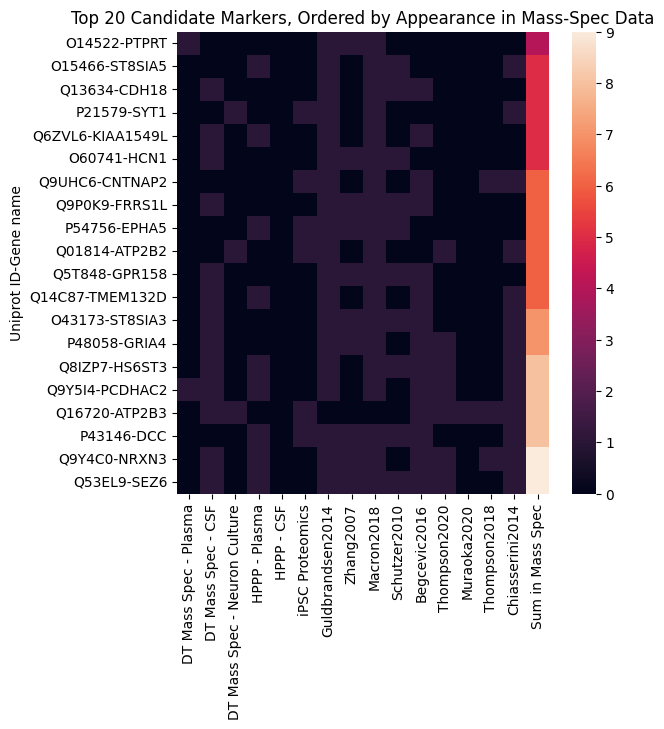

In [45]:
# creating new dataframe to store only genes decided as specific
specific_tau_cols = list(master_tau_df.columns) + ['scRNAseq Rank', 'scRNAseq Attribution'] + mass_spec_names + ['Sum in Mass Spec'];
specific_tau = pd.DataFrame(np.zeros((master_tau_df.shape[0],len(specific_tau_cols))),
                            columns = specific_tau_cols);
print(specific_tau.columns)
g2sc_rank = {g : r+1 for r,g in enumerate(scrna_data['gene'])}
g2sc_attr = {g : a for g,a in zip(scrna_data['gene'], scrna_data['attribution'])}

# if clustering is used
if cluster_tau:
    pred_clusters = KMeans(n_clusters = n_clusters).fit_predict(master_tau_df.values[:,:2])
    master_tau_df['Cluster'] = pred_clusters;
    
    #plotting clustering results
    plt.figure(figsize = (10,10))
    sns.scatterplot(x = 'Brain_RNA-Seq', y = 'GTEx', hue = 'Cluster',
                    palette = 'Set2', data = master_tau_df);
    plt.title('Tau values')
    plt.savefig('tau_clustering.pdf')
    
    #finding "best cluster" which will we say to have maximum average tau values
    best_cluster = 0
    best_score = -1;
    for cluster in range(0,n_clusters):
        score = sum(np.ravel(master_tau_df[master_tau_df['Cluster'] == cluster].values[:,:4]))
        if score > best_score:
            best_cluster = cluster;
            best_score = score;
    
    #creating new dataframe to store just this cluster
    specific_tau = master_tau_df.loc[master_tau_df.Cluster == best_cluster]

# otherwise just use individual cutoffs for GTEx and Brain RNA-seq
else:
    rows = []
    for i in range(0, master_tau_df.shape[0]):
        row = master_tau_df.iloc[i]
        if row['GTEx'] > brain_tau_cutoff and row['Brain_RNA-Seq'] > cell_type_tau_cutoff:
            rows.append(i)
    specific_tau = master_tau_df.iloc[rows,:]


#isolating uniprot IDs for just specific genes
specific_uniprots = [u for (u,g) in np.ravel(specific_tau.index)]

ranks = []; attributions = []
for u in specific_uniprots:
    if u2g[u] in g2sc_rank:
        ranks.append(g2sc_rank[u2g[u]])
        attributions.append(g2sc_attr[u2g[u]])
    else:
        ranks.append(23000)
        attributions.append(0)
specific_tau['scRNAseq Rank'] = ranks ; specific_tau['scRNAseq Attribution'] = attributions;
#searching mass_spec data
for name, data in zip(mass_spec_names, mass_spec_data):
    specific_tau.loc[:,name] = [int(uniprot in data) for uniprot in specific_uniprots]

#calculate sum of appearances and sort
specific_tau.loc[:,'Sum in Mass Spec'] = np.sum(specific_tau.values[:,-len(mass_spec_names):],
                                                axis = 1);
specific_tau['Transmembrane'] = [u in allTMU for u in specific_uniprots]
specific_tau = specific_tau.sort_values('Sum in Mass Spec')
path = '../results/20230911_brain_specific_tau_' + brain_cell_type + 'allprot.csv'
specific_tau.to_csv(path)

#plot a heatmap of the top 20 candidates
plt.figure(figsize = (6,6));
sns.heatmap(specific_tau.iloc[-20:,-(len(mass_spec_names)+2):-1]);
plt.title('Top 20 Candidate Markers, Ordered by Appearance in Mass-Spec Data');

In [ ]:
from scipy.stats import spearmanr

for col in master_tau_df.columns:
    plt.figure()
    ranks = np.argsort(np.argsort(specific_tau[col]*-1))
    plt.scatter(ranks, np.log(specific_tau['scRNAseq Rank']))
    plt.xlabel(col); plt.ylabel('Graham ranks')
    print(col, spearmanr(ranks, specific_tau['scRNAseq Rank']))

In [ ]:
for data, name in zip(tau_dfs, df_names):
    ranks = []; attrs = []
    for u in data['Gene']:
        if u in u2g:
            if u2g[u] in g2sc_attr:
                ranks.append(g2sc_rank[u2g[u]])
                attrs.append(g2sc_attr[u2g[u]])
            else:
                ranks.append(3.5e4)
                attrs.append(0)
        else:
            ranks.append(3.5e4)
            attrs.append(0)

    new_rank = []
    new_attr = []
    new_tau = []

    for i, r in enumerate(ranks):
        if r == 3.5e4:
            continue
        else:
            new_rank.append(r)
            new_attr.append(attrs[i])
            new_tau.append(data.iloc[i]['Tau'])
            
    plt.figure()
    plt.title('All genes: Graham attribution vs attribution of Tau in {}'.format(name))
    plt.scatter(np.log(new_attr), new_tau, alpha = 0.03)
    plt.xlabel('Graham\'s attribution'); plt.ylabel('{} Tau'.format(name));
    
    plt.figure()
    plt.title('All genes: Graham vs rank of Tau in {}'.format(name))
    plt.scatter(new_rank, (np.array(new_tau)*-1).argsort().argsort(), alpha = 0.03)
    plt.xlabel('Graham\'s ranks'); plt.ylabel('{}Tau Ranking'.format(name));
    print(spearmanr(new_rank, np.argsort(np.argsort(np.array(new_tau)*-1))))

In [ ]:
val_list = scrna_data['attribution'].values
width = 0.0002
plt.figure(figsize = (5,5))
[xx,yy] = kde(val_list, width);
plt.plot(xx,yy, linewidth= 3);
plt.title('Smoothened Histogram of scRNA attributions for neurons')
plt.ylabel('Proportional Density')
plt.xlabel('Tau Score')

full_path = '../results/graham_density.pdf'
plt.savefig(full_path,transparent = True, dpi = 600)

k = sum(scrna_data['attribution'].values > 0.001)


graham_specific_uniprots = []; graham_ranks = []; graham_genes = [];
valid = 0
tm_graham = 0
for i, gene in enumerate(scrna_data['gene']):
    if i < 412:
        if gene in g2u or gene in oldg2u:
            valid += 1
            if g2u[gene] in allTMU:
                tm_graham +=1
                u = g2u[gene]
                graham_ranks.append(scrna_data.iloc[i]['attribution'])
                graham_genes.append(gene)
                graham_specific_uniprots.append(u)
        else:
            print(gene)
print(valid, tm_graham)
graham_cols = ['scRNAseq Attr.'] + mass_spec_names + ['Sum in Mass Spec'];
graham_df = pd.DataFrame(np.zeros((len(graham_genes),len(graham_cols))), columns = graham_cols)
        
graham_df['Uniprot ID'] = graham_specific_uniprots
graham_df['Gene Name'] = graham_genes
graham_df['scRNAseq Attr.'] = np.array(graham_ranks) / np.max(graham_ranks)
graham_df = graham_df.set_index('Uniprot ID')
graham_df = graham_df.set_index('Gene Name', append= True)
                            
#searching mass_spec data
for name, data in zip(mass_spec_names, mass_spec_data):
    graham_df.loc[:,name] = [int(uniprot in data) for uniprot in graham_specific_uniprots]

#calculate sum of appearances and sort
graham_df.loc[:,'Sum in Mass Spec'] = np.sum(graham_df.values[:,-len(mass_spec_names):-1],
                                                axis = 1);
graham_df.loc[:,'Sum in Our Mass Spec'] = np.sum(graham_df.values[:,-(len(mass_spec_names)+4):-(len(mass_spec_names)-2)],
                                                axis = 1);
                         
graham_df = graham_df.sort_values('DT Mass Spec - Plasma')
path = '../results/20230728_graham_' + brain_cell_type + '.csv'
graham_df.to_csv(path)

#plot a heatmap of the top 20 candidates
plt.figure(figsize = (6,6));
sns.heatmap(graham_df.iloc[-20:,:-2]);
plt.title('Top 100 Candidate Markers, Ordered by Graham\'s Attribution');


In [ ]:
specific_tau_old = pd.read_csv('../results/specific_tau_07_neurons.csv')
specific_uniprots = uniprot_conversion(specific_tau_old['Gene'], g2u, oldg2u)
print(len(intersection(graham_specific_uniprots, specific_uniprots)))
print(sum(graham_df['DT Mass Spec - CSF']), sum(graham_df['DT Mass Spec - Plasma']))

In [ ]:
missing_genes = []
new_genes = [i[1] for i in specific_tau.index.values]
new_uniprots = [i[0] for i in specific_tau.index.values]
counter = 0

def print_profile(u, df_name):
    if u in u2g:
        g = u2g[u]
        case = 0
    elif u in oldu2g:
        g = oldu2g[u]
        case = 1
    else:
        print('Failed, no proper conversion for this uniprot')
        return ['null']
    
    
    df = dfs[df_names.index(df_name)]
    gene_list = list(gene_lists[df_names.index(df_name)])
    
    if g in gene_list:
        return df.iloc[gene_list.index(g)]
    elif case == 0 and u in oldu2g[u]:
        g = oldu2g[u]
        print('Had to use old case')
        if g in gene_list:
            return df.iloc[gene_list.index(g)]
    else:
        print('Can\'t find this gene in the dataframe')
        return ['null']
    
for g in specific_tau_old.Gene:
    if g not in new_genes:
        missing_genes.append(g)
        if g in g2u:
            u = g2u[g]
        elif g in oldg2u:
            u = oldg2u[g]
        else:
            u = 'null'
            
            
        if u in u2g:
            setg = u2g[u]
        else:
            setg = oldu2g[u]
            
        if (u,setg) in list(master_tau_df.index.values):
            continue
        elif u in new_uniprots:
            continue
        else:
            print(counter)
            print('Missing', g)
            
            if u in list(cell_type_tau.Gene):
                tau_row = list(cell_type_tau.Gene).index(u)
                print('Found in tau dataframe',cell_type_tau.iloc[tau_row])
            else:
                print('not in tau')
                
            counter += 1
            print('\n')

In [ ]:
graham_ms = []; tau_ms = [];
specific_uniprots = [u for (u,g) in np.ravel(specific_tau.index)]
print(len(specific_uniprots))
# specific_uniprots = uniprot_conversion(specific_tau_old['Gene'], g2u, oldg2u)
for uniprot in graham_specific_uniprots:
    if uniprot in mass_spec_csf_cc or uniprot in mass_spec_plasma_cc:
           graham_ms.append(uniprot) 
            
for uniprot in specific_uniprots:
    if uniprot in mass_spec_csf_cc or uniprot in mass_spec_plasma_cc:
           tau_ms.append(uniprot) 
print(len(tau_ms))
d = intersection(graham_ms, tau_ms)
d.sort()
for uniprot in d:
    print(u2g[uniprot])
print(len(intersection(graham_ms, tau_ms)))

In [ ]:
len(graham_ms)

In [ ]:
brs_tau.iloc[u2idx_dicts[1][g2u['CALY']]]
compiled_brs.iloc[2885]

5196